## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [165]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [166]:
def covariance_matrix_products(x, y):
    X = x.reshape(-1, 28 * 28).astype(np.float32)
    X_mean = X.mean(axis=0)
    X -= X_mean
    cov = np.dot(X.T, X) / X.shape[0]
    U, S, _ = np.linalg.svd(cov)
    
    return U, S

## Загружаем исходные данные

In [4]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

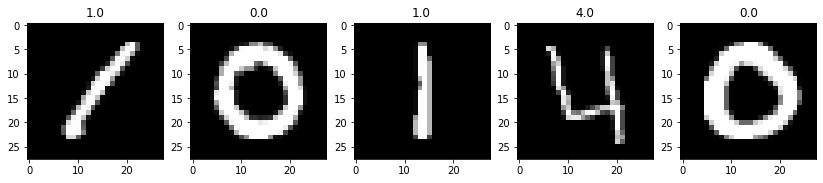

In [124]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Модель с использованием PCA

Делим данные на тренировочную и валидационную выборку

In [125]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.1,
    random_state=42)

Ищем собственные вектора

In [126]:
U, S = covariance_matrix_products(x_train, y_train)

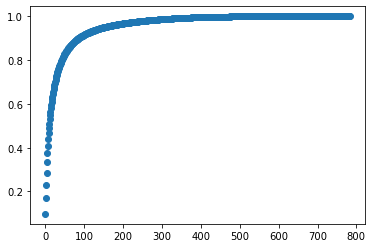

In [127]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

Понижаем размерность

In [128]:
S_thr = 0.8  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=42 S=0.800


In [129]:
x_train_reduced = np.dot(x_train.reshape(-1, 28 * 28).astype(np.float32), U[:, :n_comp])
x_val_reduced = np.dot(x_val.reshape(-1, 28 * 28).astype(np.float32), U[:, :n_comp])

In [130]:
print(x_train_reduced.shape)
print(x_val_reduced.shape)

(37800, 42)
(4200, 42)


Строим модель на преобразованных данных - модель возьмем простейшую логистическую регрессию

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [132]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(x_train_reduced)
standardized_val_data = scaler.transform(x_val_reduced)

In [133]:
model = LogisticRegression(max_iter=10000)
model.fit(standardized_data, y_train)

LogisticRegression(max_iter=10000)

In [134]:
model.score(standardized_data, y_train)

0.9065343915343915

Посмотрим на результаты на валидации

In [135]:
from sklearn.metrics import classification_report
print(classification_report(y_val, model.predict(standardized_val_data)))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       408
         1.0       0.97      0.97      0.97       471
         2.0       0.88      0.89      0.88       420
         3.0       0.89      0.83      0.86       506
         4.0       0.88      0.91      0.89       397
         5.0       0.83      0.83      0.83       339
         6.0       0.91      0.93      0.92       402
         7.0       0.92      0.89      0.90       438
         8.0       0.86      0.87      0.86       403
         9.0       0.86      0.88      0.87       416

    accuracy                           0.90      4200
   macro avg       0.89      0.90      0.90      4200
weighted avg       0.90      0.90      0.90      4200



Предсказываем на тестовых данных:

In [136]:
x_test_reduced = np.dot(test_img.reshape(-1, 28 * 28).astype(np.float32), U[:, :n_comp])
x_test = scaler.transform(x_test_reduced)
prediction = model.predict(x_test)

In [137]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [138]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


# Сделаем то же самое но на результатах HOG дескриптора

In [152]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [153]:
def hog_prep(x):
    return hog.compute(np.uint8(x))

Преобразуем все изображения в гистограммы направленных векторов

In [154]:
x_train_hog = np.array([hog_prep(i) for i in train_img])
x_test_hog = np.array([hog_prep(i) for i in test_img])

выделим валидационную выборку

In [155]:
y_train_hog, y_val_hog, x_train_hog, x_val_hog = train_test_split(
    train_label, x_train_hog, test_size=0.1,
    random_state=42)

In [156]:
print(x_train_hog.shape)
print(x_val_hog.shape)
print(x_test_hog.shape)

(37800, 144, 1)
(4200, 144, 1)
(28000, 144, 1)


отмасштабируем данные

In [157]:
hog_scaler = StandardScaler()
x_train_hog = hog_scaler.fit_transform(x_train_hog.reshape(x_train_hog.shape[0],x_train_hog.shape[1]))
x_val_hog = hog_scaler.transform(x_val_hog.reshape(x_val_hog.shape[0],x_val_hog.shape[1]))
x_test_hog = hog_scaler.transform(x_test_hog.reshape(x_test_hog.shape[0],x_test_hog.shape[1]))

In [158]:
print(x_train_hog.shape)
print(x_val_hog.shape)
print(x_test_hog.shape)

(37800, 144)
(4200, 144)
(28000, 144)


Построим ту же логистическую регрессию, но уже на результатах HOG преобразования

In [159]:
hog_model = LogisticRegression(max_iter=10000)
hog_model.fit(x_train_hog, y_train_hog)

LogisticRegression(max_iter=10000)

In [160]:
hog_model.score(x_train_hog, y_train_hog)

0.9802645502645503

In [161]:
print(classification_report(y_val_hog, hog_model.predict(x_val_hog)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       408
         1.0       0.97      0.99      0.98       471
         2.0       0.98      0.96      0.97       420
         3.0       0.97      0.97      0.97       506
         4.0       0.97      0.95      0.96       397
         5.0       0.97      0.96      0.96       339
         6.0       0.97      0.99      0.98       402
         7.0       0.96      0.94      0.95       438
         8.0       0.93      0.96      0.94       403
         9.0       0.95      0.95      0.95       416

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



Видим, что результат получше, чем в случае с PCA

Предскажем значения для загрузки в kaggle

In [162]:
prediction = hog_model.predict(x_test_hog)

In [163]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [164]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


### После загрузки в kaggle оценка - 0.96525, что нас более чем устраивает